In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
D1_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D1/"
D2_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D2/"
ds_type = D1_LINEAR_GAUSIAN_250px
dataset_path = signature_types = os.listdir(ds_type)
signs = []
for item in signature_types:
  all_signs = os.listdir(ds_type+"/"+item)
  for sign in all_signs:
    if sign.endswith(".db"):
      pass
    else: 
      signs.append((item, str(ds_type+"/"+item) + "/" + sign))
signs_df = pd.DataFrame(data = signs, columns = ["sign type", "image"])
sign_count = signs_df["sign type"].value_counts()
print("Signatures in each category:")
print(sign_count)

Signatures in each category:
fogeries    1320
original    1320
Name: sign type, dtype: int64


In [3]:
images = []
labels = []
for i in signature_types:
  data_path = ds_type + str(i)
  filenames = [i for i in os.listdir(data_path)]
  for f in tqdm(filenames, desc=f"Processing {i}"):
    if f.endswith(".db"):
      pass
    else:
      img = cv2.imread(data_path + "/" + f)
      images.append(img)
      labels.append(i)

Processing original: 100%|██████████| 1320/1320 [00:09<00:00, 134.68it/s]


In [4]:
images = np.array(images)
images = images.astype('float32') / 255.0

In [5]:
y = signs_df['sign type'].values
y = y.reshape(-1,1)
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
Y=np.array(columnTransformer.fit_transform(y),dtype='float32')
print(Y.shape)

(2640, 2)


In [6]:
images, Y = shuffle(images,Y,random_state=42)
train_x,test_x,train_y,test_y = train_test_split(images, Y, test_size=0.2, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2112, 250, 250, 3)
(528, 250, 250, 3)
(2112, 2)
(528, 2)


In [7]:
train_x = train_x / 255.0
test_x = test_x / 255.0

In [8]:
from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model, Sequential

In [9]:
image_size = [250,250]
model = VGG16(input_shape=image_size+[3], include_top=False, weights='imagenet')

In [10]:
# model.summary()

In [11]:
for layers in model.layers:
  layers.trainable = False

In [12]:
final_arc = Model(inputs=model.input,outputs=Dense(2,activation='softmax')(Flatten()(model.output)))

In [13]:
# final_arc.summary()

In [14]:
final_arc.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=['accuracy'])

In [15]:
history = final_arc.fit(train_x, train_y, validation_data=(test_x,test_y), epochs = 100)

Epoch 1/100
66/66 [==============================] - 20s 193ms/step - loss: 0.7744 - accuracy: 0.5024 - val_loss: 0.6907 - val_accuracy: 0.5208
Epoch 2/100
66/66 [==============================] - 9s 142ms/step - loss: 0.7681 - accuracy: 0.4976 - val_loss: 0.9328 - val_accuracy: 0.4792
Epoch 3/100
66/66 [==============================] - 9s 143ms/step - loss: 0.7405 - accuracy: 0.5066 - val_loss: 0.7637 - val_accuracy: 0.5208
Epoch 4/100
66/66 [==============================] - 9s 143ms/step - loss: 0.7221 - accuracy: 0.5085 - val_loss: 0.7064 - val_accuracy: 0.5208
Epoch 5/100
66/66 [==============================] - 9s 143ms/step - loss: 0.7695 - accuracy: 0.5099 - val_loss: 0.6815 - val_accuracy: 0.5208
Epoch 6/100
66/66 [==============================] - 9s 143ms/step - loss: 0.6982 - accuracy: 0.5303 - val_loss: 0.7062 - val_accuracy: 0.5208
Epoch 7/100
66/66 [==============================] - 9s 143ms/step - loss: 0.7063 - accuracy: 0.5080 - val_loss: 0.7129 - val_accuracy: 0.479

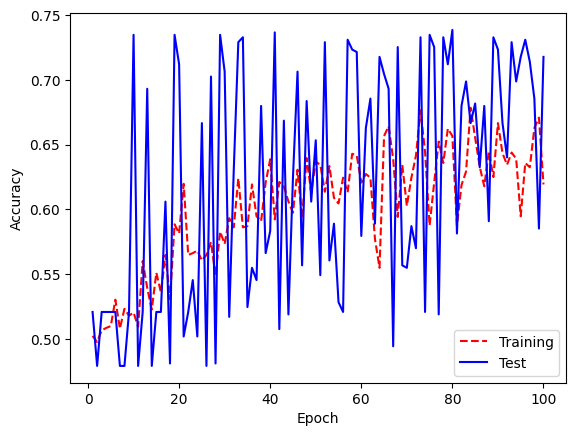

In [16]:
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(training_acc) + 1)
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [17]:
testing = final_arc.evaluate(test_x, test_y)
predictions = final_arc.predict(test_x)
pred_y = np.argmax(predictions, axis = 1)
test_y = np.argmax(test_y, axis=1)
print(classification_report(test_y,pred_y))

17/17 [==============================] - 3s 145ms/step
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       275
           1       0.66      0.87      0.75       253

    accuracy                           0.72       528
   macro avg       0.74      0.72      0.71       528
weighted avg       0.74      0.72      0.71       528



In [18]:
cm = confusion_matrix(test_y, pred_y)
print(cm)

[[160 115]
 [ 34 219]]
